# Image Classification

We show in this tutorial how to use DRAGON for image classification task. We need to create a search space with two graphs, one treating 2D data, and a second one treating 1D data.

## Loading the dataset

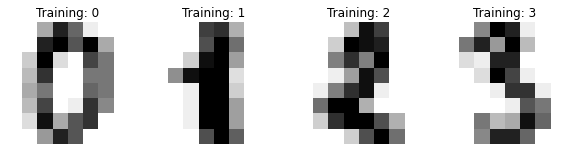

In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt

digits = load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)


In [2]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    digits.images, digits.target, test_size=0.5, shuffle=False
)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}, X_val: {X_test.shape}, y_val: {y_test.shape}")

X_train: (898, 8, 8), y_train: (898,), X_val: (899, 8, 8), y_val: (899,)


## Defining the Loss function

#### DNN definition

In [3]:
import torch
import torch.nn as nn
import numpy as np
import os 
from dragon.search_space.cells import WeightsAdjCell, set_node, set_cell

class ClassificationDNN(nn.Module):
    def __init__(self, args, input_shape) -> None:
        super().__init__()
        self.input_shape = input_shape
        set_cell(args['2D Dag'], self.input_shape)
        self.dag_2d = WeightsAdjCell(args['2D Dag'])

        flat_shape = (np.prod(self.dag_2d.output_shape),)
        set_cell(args['1D Dag'], flat_shape)
        self.dag_1d = WeightsAdjCell(args['1D Dag'])

        self.output = args["Out"]
        set_node(self.output, self.dag_1d.output_shape)

    def forward(self, X, **kwargs):
        out_2d = self.dag_2d(X)
        flat = nn.Flatten()(out_2d)
        out_1d = self.dag_1d(flat)
        out = self.output(out_1d)
        return out

    def save(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        full_path = os.path.join(path, "best_model.pth")
        torch.save(self.state_dict(), full_path)

### Search Space Definition

In [4]:
from dragon.search_space.variables import mlp_var, dropout, identity_var, operations_1d_var, operations_2d_var, mlp_const_var, conv_2d, pooling_2d, dag_var, node_var
from dragon.search_space.zellij_variables import ArrayVar
from dragon.search_algorithm.zellij_neighborhoods import ArrayInterval

candidate_operations_2d = operations_2d_var("2D Candidate operations", size=10, 
                                            candidates=[mlp_var("MLP"), identity_var("Identity"), dropout('Dropout'), conv_2d('Conv 2d', max_out=8), pooling_2d("Pooling")])
dag_2d = dag_var("2D Dag", candidate_operations_2d)

candidate_operations_1d = operations_1d_var("1D Candidate operations", size=10, 
                                            candidates=[mlp_var("MLP"), identity_var("Identity"), dropout('Dropout')])
dag_1d = dag_var("1D Dag", candidate_operations_1d)
out = node_var("Out", operation=mlp_const_var('Operation', 10), activation_function=nn.Softmax())

search_space = ArrayVar(dag_2d, dag_1d, out, label="Search Space", neighbor=ArrayInterval())

p1, p2 = search_space.random(2)

### DNN Training

In [5]:
import numpy as np
from skorch import NeuralNetClassifier
from sklearn.metrics import accuracy_score
from dragon.utils.tools import set_seed

def train_and_predict(args, *kwargs, verbose=False):
    set_seed(0)
    labels = [e.label for e in search_space]
    args = dict(zip(labels, args))
    model = ClassificationDNN(args, input_shape=(8,8,1))
    trainer = NeuralNetClassifier(
        model,
        max_epochs=10,
        lr=0.01,
        iterator_train__shuffle=True,
        verbose=verbose,
        
    )
    trainer.fit(np.expand_dims(X_train.astype(np.float32), axis=-1), y_train.astype(np.int64))
    y_pred = trainer.predict(np.expand_dims(X_test.astype(np.float32), axis=-1))
    acc = accuracy_score(y_test, y_pred)
    return - acc, model # We are optimizing a minimization problem
loss_1, model_1 = train_and_predict(p1,verbose=True)
loss_2, model_2 = train_and_predict(p2,verbose=True)

print("P1 ==> accuracy: ", np.round(-loss_1*100,2), "%\n")
print("P2 ==> accuracy: ", np.round(-loss_2*100,2), "%")

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.0396       0.1278        2.3028  1.5242
      2        2.2994       0.1111        2.3022  1.9906
      3        2.3002       0.1167        2.3021  2.5738
      4        2.2927       0.1222        2.2986  1.2579
      5        2.3047       0.1167        2.3014  1.4592
      6        2.2941       0.1000        2.2997  1.5178
      7        2.2903       0.1111        2.2953  1.5649
      8        2.2843       0.1389        2.2913  1.2581
      9        2.2654       0.1167        2.2873  2.3742
     10        2.2700       0.1111        2.2905  1.2845
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.6477       0.2167        2.2485  4.3544
      2        2.1965       0.2667        2.1473  4.2814
      3        1.8851       0.3667        1.8128  4.4394
      4        1.6035       0.4

### Implementing an optimization strategy


In [6]:
import time
from dragon.search_algorithm.ssea import SteadyStateEA

search_algorithm = SteadyStateEA(search_space, n_iterations=20, population_size=5, selection_size=3, evaluation=train_and_predict, save_dir="save/test_image/")
start_time = time.time()
min_loss = search_algorithm.run()
end_time = time.time() - start_time
print(f"Best score: {np.round(-min_loss*100,2)}%\nComputation time: {np.round(end_time,2)} seconds")

2024-09-20 16:38:43,555 | WARNING | Install mpi4py if you want to use the distributed version.
2024-09-20 16:38:43,564 | INFO | The whole population has been created (size = 5), 5 have been randomy initialized.
2024-09-20 16:38:43,565 | INFO | We start by evaluating the whole population (size=5)
2024-09-20 16:39:53,761 | INFO | Best found ! -0.5072302558398221 < inf
2024-09-20 16:40:06,813 | INFO | Best found ! -0.5761957730812013 < -0.5072302558398221
2024-09-20 16:40:23,679 | INFO | Best found ! -0.8353726362625139 < -0.5761957730812013
2024-09-20 16:40:24,647 | INFO | All models have been at least evaluated once, t = 5 < 20.
2024-09-20 16:40:24,829 | INFO | Evolving 1 and 3 to 6 and 7
2024-09-20 16:40:38,111 | INFO | Replacing 2 by 5
2024-09-20 16:40:39,366 | INFO | Replacing 4 by 6
2024-09-20 16:40:39,386 | INFO | Best found ! -0.8909899888765295 < -0.8353726362625139
2024-09-20 16:40:39,425 | INFO | Evolving 6 and 3 to 8 and 9
2024-09-20 16:40:41,067 | INFO | Replacing 5 by 7
2024

Starting with a completely random sets of DNNs, we managed in a few minutes to converge towards an accuracy higher than 92%.

In [7]:
from dragon.utils.plot_functions import load_archi
set_seed(0)
best_args =load_archi('save/test_image/best_model/x.pkl')
labels = [e.label for e in search_space]
best_args = dict(zip(labels, best_args))
model = ClassificationDNN(best_args, (8,8,1))
model.load_state_dict(torch.load('save/test_image/best_model/best_model.pth'))

model = NeuralNetClassifier(
    model,
    max_epochs=1,
    lr=0.0001,
    iterator_train__shuffle=True,
    verbose=False,
    
)
model.fit(np.expand_dims(X_train.astype(np.float32), axis=-1), y_train.astype(np.int64))
y_pred = model.predict(np.expand_dims(X_test.astype(np.float32), axis=-1))
acc = accuracy_score(y_test, y_pred)

print("Final accuracy: ", np.round(acc*100,2), "%\n")

Final accuracy:  94.1 %



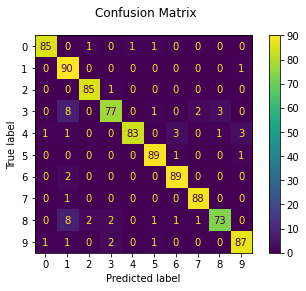

In [8]:
from sklearn import metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

Model giving a score of 94.1%:


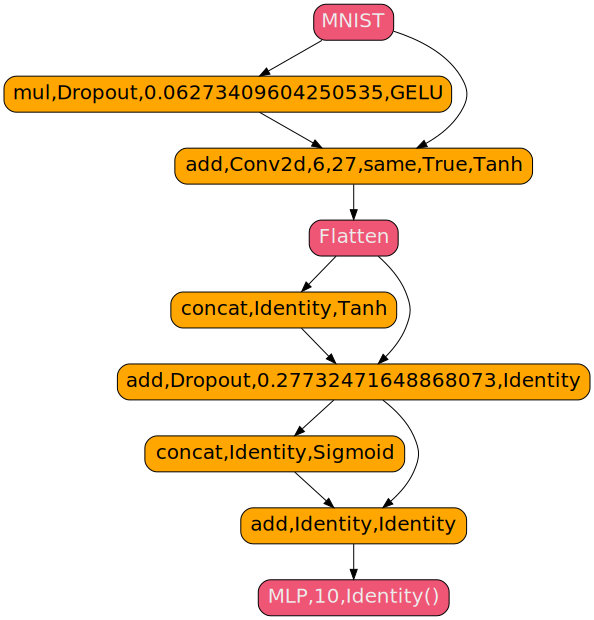

In [11]:
import graphviz
from dragon.utils.plot_functions import draw_cell, str_operations

def draw_graph(n_dag2, m_dag2, n_dag1, m_dag1, output_file, act="Identity()", name="MNIST"):
    G = graphviz.Digraph(output_file, format='pdf',
                            node_attr={'nodesep': '0.02', 'shape': 'box', 'rankstep': '0.02', 'fontsize': '20', "fontname": "sans-serif"})

    G, g_nodes = draw_cell(G, n_dag2, m_dag2, "#ffa600", [], name_input=name,
                            color_input="#ef5675")
    G.node("Flatten", style="rounded,filled", color="black", fillcolor="#CE1C4E", fontcolor="#ECECEC")
    G.edge(g_nodes[-1], "Flatten")

    G, g_nodes = draw_cell(G, n_dag1, m_dag1, "#ffa600", g_nodes, name_input=["Flatten"],
                            color_input="#ef5675")

    G.node(','.join(["MLP", "10", act]), style="rounded,filled", color="black", fillcolor="#ef5675", fontcolor="#ECECEC")
    G.edge(g_nodes[-1], ','.join(["MLP", "10", act]))
    return G

m_dag2 = best_args['2D Dag'].matrix
n_dag2 = str_operations(best_args["2D Dag"].operations)

m_dag1 = best_args['1D Dag'].matrix
n_dag1 = str_operations(best_args["1D Dag"].operations)

graph = draw_graph(n_dag2, m_dag2, n_dag1, m_dag1, "save/test_image/best_archi")
print(f'Model giving a score of {np.round(acc*100,2)}%:')
graph